In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy as sp
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import itertools
from colour import Color
from datetime import date
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.metrics import r2_score as R2S
import cairo

## Names and Palette ##

In [2]:
today = date.today()
print("Today's date:", today)
date = str(today)
date

Today's date: 2023-09-19


'2023-09-19'

In [45]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
EBconc = '[EB1] ' r'$(n M)$'
DCX = 'DCX'
Type = 'DCX Type'

Concentration = 'Concentration ' r'$(\mu M)$'
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'

In [4]:
Type_order = ['None', 'Y64N','R76S','R102S', 'R178L', 'P191R', 'G223E','R303X', 'WT']

category_Type = CategoricalDtype(Type_order, ordered=True,) #order mutants

In [5]:
black = '#000000'
grey = '#777777'
blue = '#23459C'
cyan = '#0089CF'
green = '#79BA1A'
purple = '#AB4A9C'
lily = '#CB81EA'
magenta = '#D80B8C'
red = '#e60000'
orange = '#FF7300'
darkorange = '#FF5B00'
lightorange = '#FFAC83'
yellow = '#FFCB05'
lightyellow = '#F9DC2D'
pink = '#FFA4CD'
StartHue1 = Color(purple)
DC1color = list(StartHue1.range_to(Color(pink),3))
StartHue2 = Color(darkorange)
DC2color = list(StartHue2.range_to(Color(lightorange),3))
print(DC1color,DC2color)

palette = [grey] + list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]

[<Color #ab4a9c>, <Color #e468b8>, <Color #ffa4cd>] [<Color #ff5b00>, <Color #ff8341>, <Color #ffac83>]


In [6]:
StartHue1 = Color(yellow)
DC1color = list(StartHue2.range_to(Color('#e468b8'),3))
DC1color

[<Color #ff5b00>, <Color #37efd4>, <Color #e468b8>]

## EB Maurer data ##

In [46]:
ebconc = np.array([2,10,50,250]) ###nM
eblifetime = np.divide([99.1,84.2,50.1,41.7],60) ## s turned into minutes
eblifesigma = np.divide([41.3,41.1,29,27.2],60)
ebn = [53,93,71,72]

In [47]:
r0 = { EBconc:ebconc, Lifetime : eblifetime, r'$\sigma$' : eblifesigma, 'n':ebn}
results0 = pd.DataFrame(data=r0)
results0

,[EB1] $(n M)$,Lifetime $(min)$,$\sigma$,n
0,2,1.651667,0.688333,53
1,10,1.403333,0.685000,93
2,50,0.835000,0.483333,71
3,250,0.695000,0.453333,72


In [48]:
YN = eblifetime
X = ebconc

In [49]:
def hill_inv(x, n,kd):
    return  (YN[-1]- YN[0]) * ( np.power(x, n)/(kd + np.power(x, n))) + YN[0]
def MM_inv(x,kd):
    return  (YN[-1]- YN[0]) * ( np.power(x, 1)/(kd + np.power(x, 1))) + YN[0]

In [50]:
coeffH, var_matrix = sp.optimize.curve_fit(hill_inv,X,YN)

variance = np.diagonal(var_matrix) #Refer [3]
SE = np.sqrt(variance)
coeffH,SE

(array([  1.78259074, 176.75113302]), array([ 0.09105924, 46.07910896]))

In [51]:
R2S(YN,hill_inv(X,coeffH[0],coeffH[1]))

0.9992823602640994

In [52]:
coeffMM, var_matrix = sp.optimize.curve_fit(MM_inv,X,YN)

variance = np.diagonal(var_matrix) #Refer [3]
SE = np.sqrt(variance)
coeffMM,SE

(array([18.58089662]), array([6.52080962]))

In [53]:
R2S(YN,MM_inv(X,coeffMM[0]))

0.9442267610809858

In [54]:
def exponential(x, scale, A, B):
    return A*((np.exp(-x/scale) )/(scale)) + B

In [55]:
coeff, var_matrix = sp.optimize.curve_fit(exponential,X,YN)

variance = np.diagonal(var_matrix) #Refer [3]
SE = np.sqrt(variance)
coeff,SE

(array([25.59669894, 26.65712923,  0.69237181]),
 array([0.96015483, 1.01972143, 0.00897959]))

In [56]:
R2S(YN,exponential(X,coeff[0],coeff[1],coeff[2]))

0.9998601636534707

In [58]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)

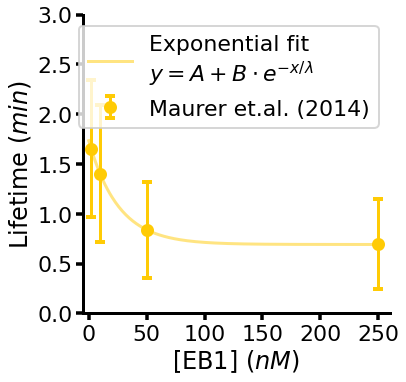

In [60]:
scattersize = 9
cap = 5

fig, ax = plt.subplots(1,1,figsize=(5.5,5.5))
ax.errorbar(ebconc , eblifetime , yerr= eblifesigma , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=yellow, alpha = 1, ls='')

linx = np.arange(0, 250, 1)
#ax.plot(linx, hill_inv(linx,coeffH[0],coeffH[1]) ,color = yellow, lw=3,ls= '-',alpha = 0.5)
#ax.plot(linx, MM_inv(linx,coeffMM[0]) ,color = grey, lw=3,ls= '-',alpha = 0.5)
ax.plot(linx, exponential(linx,coeff[0],coeff[1],coeff[2]) ,color = yellow, lw=3,ls= '-',alpha = 0.5)

ax.set_ylim(0,3)
ax.set_xlim(-5,260)
ax.set_xlabel(EBconc)
#ax.set_xticks(np.arange(0, 22.1, 2))
ax.set_xticks(np.arange(0, 250.1, 50))
ax.set_ylabel(Lifetime) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

#ax.legend(('Hill n = 1.8','Michaelis Menten','Exponential'),loc='upper right')
ax.legend(('Exponential fit \n'r'$y = A + B \cdot e^{-x/ \lambda}$', 'Maurer et.al. (2014)'),loc='upper right')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

plt.savefig(path/('expfit_MaurerEB_'+date+'.svg'))

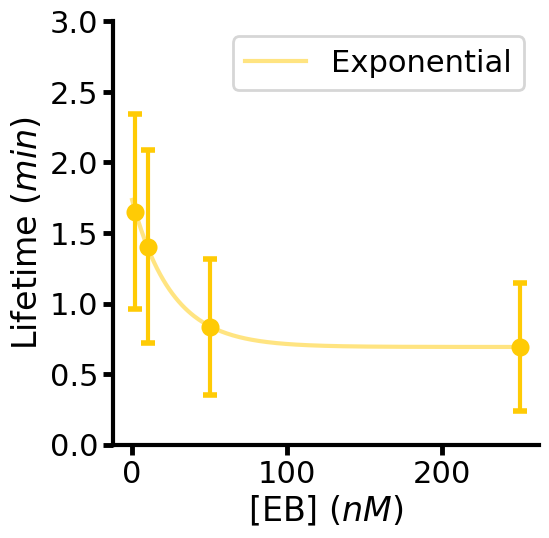

In [99]:
scattersize = 9
cap = 5

fig, ax = plt.subplots(1,1,figsize=(5.5,5.5))
ax.errorbar(ebconc , eblifetime , yerr= eblifesigma , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=yellow, alpha = 1, ls='')

linx = np.arange(0, 250, 1)
ax.plot(linx, exponential(linx,coeff[0],coeff[1],coeff[2]) ,color = yellow, lw=3,ls= '-',alpha = 0.5)

ax.set_ylim(0,3)
# ax.set_xlim(3,6)
ax.set_xlabel(EBconc)
#ax.set_xticks(np.arange(0, 22.1, 2))
#ax.set_yticks(np.arange(0, 150.1, 25))
ax.set_ylabel(Lifetime) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

ax.legend(('Exponential',),loc='upper right')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

#plt.savefig(newmydir/('logexpHillfit_ShrinkR76S_'+date+'.svg'))

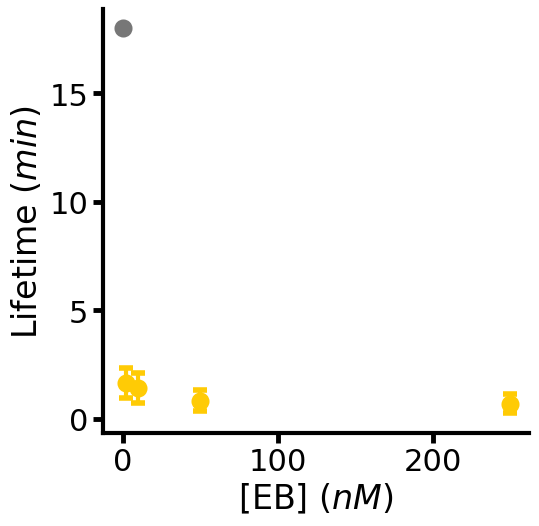

In [41]:
scattersize = 9
cap = 5

fig, ax = plt.subplots(1,1,figsize=(5.5,5.5))
ax.errorbar(ebconc , eblifetime , yerr= eblifesigma , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=yellow, alpha = 1, ls='')
ax.errorbar(0 , 18 , yerr= 0 , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=grey, alpha = 1, ls='')

x0 = np.arange(3.3, 4.8, 0.05)
#ax.plot(x0, x0*m+b,color = pink00, lw=3,ls= '-',alpha = 0.5)

#ax.set_ylim(-2.5,3)
# ax.set_xlim(3,6)
ax.set_xlabel(EBconc)
#ax.set_xticks(np.arange(0, 22.1, 2))
#ax.set_yticks(np.arange(0, 150.1, 25))
ax.set_ylabel(Lifetime) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

#ax.legend((r'$n=2.94 \pm 0.49$' '\n' r'$R^2 > 0.945$',),loc='lower right',title='Hill Equation')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

#plt.savefig(newmydir/('logexpHillfit_ShrinkR76S_'+date+'.svg'))

In [43]:
def hillEQ_inv(x, n, kd):
    return  (eblifetime[-1]- 18) * ( np.power(x, n)/(kd + np.power(x, n))) + 18

In [48]:
X = [0,2,10,50,250]
YL = np.divide([1083,99.1,84.2,50.1,41.7],60)

In [49]:
logx = np.log(X[1:-1])
normy =( YL[1:-1]-YL[0])/(YL[-1]-YL[0])
logy = np.log(normy/(1-normy))

p, cov = np.polyfit(logx, logy, 1, cov=True)
var = np.diagonal(cov) #Refer [3]
SElin = np.sqrt(var) #Refer [4]

m,b = p

p, SElin

(array([0.61214352, 2.19396225]), array([0.24021728, 0.63685939]))

NameError: name 'newmydir' is not defined

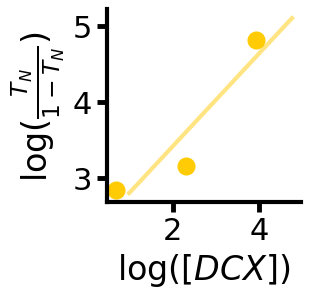

In [52]:
scattersize = 9
cap = 5

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.errorbar(logx , logy , yerr= 0 , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=yellow, alpha = 1, ls='')

x0 = np.arange(1, 4.8, 0.05)
ax.plot(x0, x0*m+b,color = yellow, lw=3,ls= '-',alpha = 0.5)

#ax.set_ylim(-2.5,3)
# ax.set_xlim(3,6)
ax.set_xlabel(r'$\log([DCX])$')
#ax.set_xticks(np.arange(0, 22.1, 2))
#ax.set_yticks(np.arange(0, 150.1, 25))
ax.set_ylabel(r'$\log(\frac{T_N}{1-T_N})$') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

#ax.legend((r'$n=2.94 \pm 0.49$' '\n' r'$R^2 > 0.945$',),loc='lower right',title='Hill Equation')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

plt.savefig(newmydir/('logexpHillfit_TimetoNucR76S_'+date+'.svg'),backend='Cairo')